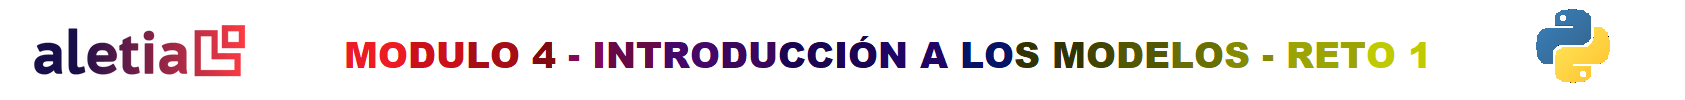

##**Repaso Regresión Lineal**

Recordemos que el modelo de regresión lineal asume que es posible estimar una variable $y$ a partir de la combinación lineal de varias variables $x_1, x_2, x_3, \cdots$ con sus coeficientes $\theta_1, \theta_2, \theta_3, \cdots$ y agregando un valor de escala $\theta_0$. A esta estimación le llamaremos $\hat{y}$

En términos matemáticos:

$y \approx \hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots$

##**Planteamiento del problema y descripción de los datos**

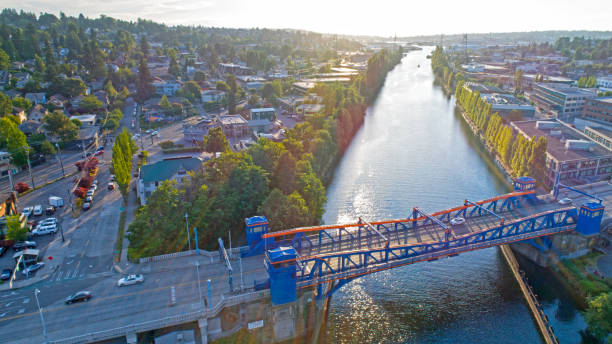
[Puente Fermont en Seattle](https://en.wikipedia.org/wiki/Fremont_Bridge_(Seattle)) 

- **RETO**
  *   **Predecir el número de viajes en bicicleta a través del puente Fermont en Seattle**

- **DATOS DISPONIBLES**
  *   Temperatura min y max
  *   Cantidad de agua por mm2
  *   Ubicación

- **ORIGEN DE LOS DATOS**
  *   [National Centers for environmental information](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (NOAA) Station ID de Seattle: `USW00024233`
  *   [Datos del gobierno de Seattle](https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD)
  *   Es interesante ver el origen de los datos pero si te da flojera puedes descargar las tablas directamente de: 
  [DATOS MODULO_4 RETO_1](https://mega.nz/#P!AgDbHSfcBEu78xaiYoUo7KL3iRtqEX1YmnEmY9h-n1v3dvZ6P1zDZT8xt-oIGj2GpU6C2ZkYSmvvnkAA-dpR9Xi7keUtTDQSMJEcjKvqlW3JicM-dEHo6w) con la contraseña: *datosreto4*
  

- **PLAN DE INGENIERÍA DE DATOS**
  *   En esta ocasión los datos que usaremos fueron previamente revisados, validados y limpios sin embargo los datos son muy simples y dificilmente podrían ayudar a tener una buena predicción por si mismos. Pero el trabajo de ingeniería de datos no solo consiste en limpiar y validar los datos sino en encontrar una **INGENIOSA** manera de transformarlos para que nos sean mas útiles, de ahí el nombre de *ingeniería*.
  *   Esta habilidad es crucial para determinar el seniority de un analista de datos y desafortunadamente no hay una metodología rígida que nos enseñe como hacerlo ya que este tipo de trabajo involucra mucha creatividad, pensamiento abstracto y holístico sobre un problema y es por eso que consideramos fundamental mostrar un ejemplo.
  *   La solución en realidad es muy simple. La parte dificil es hacer que esa solución emerja del planteamiento del problema y los datos disponibles.
  *   Plan: Convertir los datos de la siguiente manera:
       *   Temperatura min y max ----------> La temperatura mínima y máxima nos puede funcionar pero en realidad queremos saber cual será el clima que propicia el uso de bicicleta
       *   Cantidad de agua por mm2 ------> La cantidad de agua en el aire no nos funciona. Pero si la probabilidad de lluvia.
       *   Ubicación ----------------------------------> La ubicación no nos sirve pero si puede determinar el número de horas con luz en el día

##**Creación de datasets e ingeniería de datos**

A continuación mostramos el código de ingeniería de datos. 

Para cada transformación aplicada mostramos la motivación que origina dicha transformación.


---



**Hint:** Nos muestra una pista del origen de la transformación

**Solución:** Nos muestra la estrategia de transformación

In [ ]:
# Importamos las bilbiotecas necesarias
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

# Cargamos los dos datasets
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)

# Calculamos el trafico diario de bicicletas
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]

# Hint: Algunos días como los fines de semana incentivan el uso de bicicleta
# Solución: Creamos las primeras 7 variables las cuales serán un ID del día de la semana
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

# Hint: Los días libres son buenos para andar en bicicleta
# Solución: Crearemos también una variable para identificar los días festivos
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

# Hint: Seattle es una ciudad donde el número de horas de luz en el día varían mucho durante el año
# Solución: Crearemos una variable que nos indique el número de horas de luz en el día
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

# Hint: El clima es importante cuando queremos salir a montar bicicleta
# Solución: Calculamos un promedio de temperatura por día 
# Agregamos una variable de probabilidad de lluvia
# Agregamos una variable para los días sin lluvia (es importante saber si habrá poca lluvia pero más importante saber si no habrá)

# Las temperaturas estan en 1/10 grados C; Convertimos los datos a grados C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])
# La precipitación esta en 1/10 mm; Convertimos a pulgadas
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

# Hint: El calentamiento global modifica las temperaturas cada año
# Sol: Creamos una variable "contador" que nos ayuda a dar al modelo intuición sobre el año en curso
daily['annual'] = (daily.index - daily.index[0]).days / 365.

# Veamos el resultado
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1.0,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1.0,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1.0,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1.0,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1.0,0.010959


##**RETO PRINCIPAL: Creación del modelo**

Ahora si viene el reto:

Agrega una columna en el dataframe ***daily*** que se llame ***predicted*** y coloca en dicha columna los valores de una predicción de trafico de bicicletas.

**Hint 1:** Las variables las creamos nosotros mismos y las conocemos a detalle. Podemos concluir que el único problema adicional es que tenemos algunos vacíos así que será el único tratamiento adicional que necesitamos y como tenemos datos suficientes los vamos a borrar. Para este reto tampoco haremos reducción de la dimensionalidad ni detección de outliers ya que sabemos (por construcción) que todas las variables son independientes y aportan de manera significativa. Además se encuentran en una escala correcta y sin outliers.

**Hint 2:** Crea un modelo de regresión lineal

**Hint 3:** sklearn tiene una clase para crear el modelo

```
from sklearn.linear_model import LinearRegression
```

La solución de esta sección se encuentra en el siguiente [link](https://mega.nz/#P!AgGqDTGUhsmpTVVIhlYIl4pqzc4LeOKqUUcMAjp_MO2yp1VC09Edyr6jW9e4Ji2mvLzqNpEYUOFBbpaCcnQjVzvURxx3AQx2rT8zrw0ISkDVal3Rnmm8zdCB5OUe3ODKQlWi3L4FWVQ)

el password lo compartiremos en la sesión de mentoría



In [ ]:
# Importamos las bibliotecas


# Eliminamos las filas con valores nulos


# Seleccionamos las variables X a utilizar
# Columnas: 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday', 'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual'


# Seleccionamos la variable Y a predecir
# Columna: 'Total'


# Creamos un modelo de regresión lineal. 
# Las variables de día de la semana funcionan como intercepto, por eso decidimos configurar la regresión para que no incluya un intercepto
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


# Entrenamos el modelo


# Calculamos la predicción


Visualización del modelo de predicción de tráfico vs trafico real

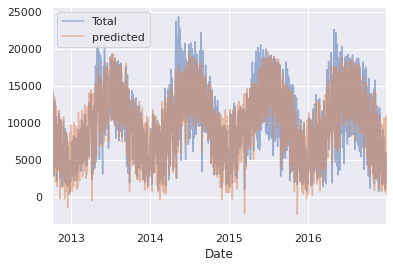

In [ ]:
daily[['Total', 'predicted']].plot(alpha=0.5);

##**Reto adicional**

En la gráfica podemos notar que el modelo funciona bastante bien. Sin embargo tenemos una oportunidad de mejora para las predicciones de verano.

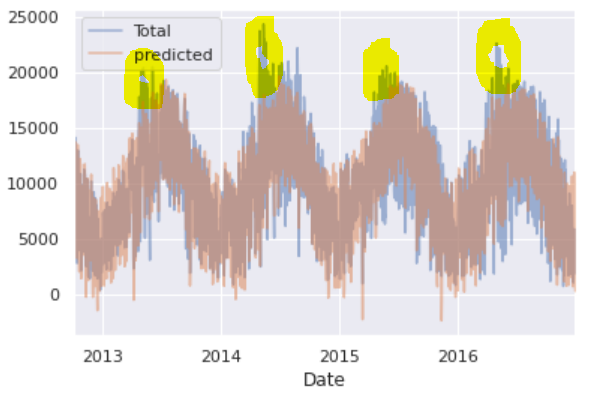

**Aprendizaje:** La creación de un modelo es un proceso experimental. Donde siempre revisamos los resultados y volvemos a preguntarnos si necesitamos mas/menos variables, mas/menos datos, mayor calidad de los datos, revisar los supuestos del modelo, etc.

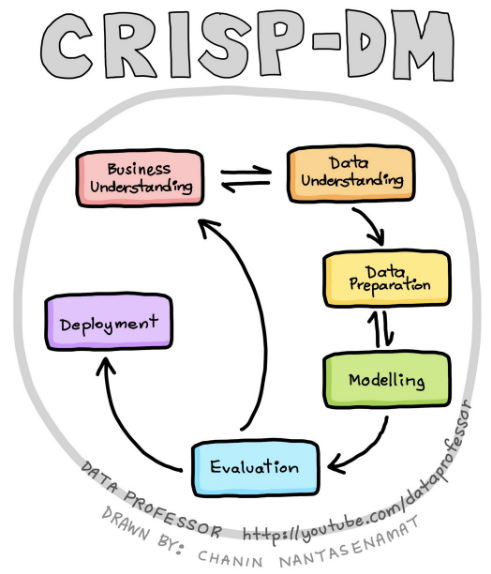

Por lo anterior el reto adicional consiste en crear nuevas variables que ayuden a mejorar la predicción anterior.

**Hint:** El modelo de regresión lineal encuentra relaciones lineales entre las variables y el target. Sin embargo es posible que haya relaciones no lineales que deban ser tomadas en consideración por ejemplo:

Primero vemos que hay una tendencia relativamente estable en la línea de base semanal: hay muchos más ciclistas entre semana que los fines de semana y días festivos. Vemos que por cada hora adicional de luz diurna, 129 ± 9 personas más eligen viajar; un aumento de temperatura de un grado centígrado anima a 65 ± 4 personas a agarrar su bicicleta; un día seco significa un promedio de 548 ± 33 ciclistas más, y cada pulgada de precipitación significa que 665 ± 62 personas más dejan su bicicleta en casa. Una vez que se toman en cuenta todos estos efectos, vemos un modesto aumento de 27 ± 18 nuevos pasajeros diarios cada año.

Es casi seguro que a nuestro modelo le falta alguna información relevante. Por ejemplo, los efectos no lineales (como los efectos de la precipitación y la temperatura fría) y las tendencias no lineales dentro de cada variable (como la falta de inclinación a montar en bicicleta a temperaturas muy frías y muy altas) no se pueden tener en cuenta en este modelo. Además, hemos descartado parte de la información más detallada (como la diferencia entre una mañana lluviosa y una tarde lluviosa) y hemos ignorado las correlaciones entre días (como el posible efecto de un martes lluvioso en las cifras del miércoles, o el efecto de un día soleado inesperado después de una racha de días lluviosos). ¡Todos estos son efectos potencialmente interesantes, y ahora tiene las herramientas para comenzar a explorarlos si lo desea!